In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
import statsmodels.formula.api as smf

from os import listdir
from os.path import isfile, join
from scipy import stats
from skimage import io

import sys
sys.path.append('..')
import src as tools

COLOR_MAP = {
    "light_orange": "#E69F00",
    "light_blue": "#56B4E9",
    "teal": "#009E73",
    "yellow": "#F0E442",
    "dark_blue": "#0072B2",
    "dark_orange": "#D55E00",
    "pink": "#CC79A7",
    "purple": "#9370DB",
    "black": "#000000",
    "silver": "#DCDCDC",
}

model_selection_df = pd.DataFrame(columns = ["Model","AIC","BIC", "R^2","Cox-Snell pseudo R^2"])

## Prepare Data 

Load 2019 and 2020 data. Drop calls with duration longer than 120 minutes.

In [2]:
df = pd.read_csv("../data/df_for_response_time_modeling.csv", index_col = 0)

df["date"] = pd.to_datetime(df["date"])
df["call_datetime"] = pd.to_datetime(df["call_datetime"])
df["disp_datetime"] = pd.to_datetime(df["disp_datetime"])
df["clrd_datetime"] = pd.to_datetime(df["clrd_datetime"])

In [9]:
# Compute response time in minutes
df["response_time"] = [t for t in df["response_time_minutes"]]
df["response_time_minutes"] = [math.ceil(t) for t in df["response_time_minutes"]]

# Drop long calls
df = df[df["response_time_minutes"] <=120].copy()

# Keep only calls for service.
df = df[df["call_type"] != "Initiated"].copy()

# # Drop one time events
df.reset_index(drop = True, inplace = True)

#### Data Transformation for Learning Pipeline

Fit time variables to cyclic splines, get one-hot for categorical and scale data.

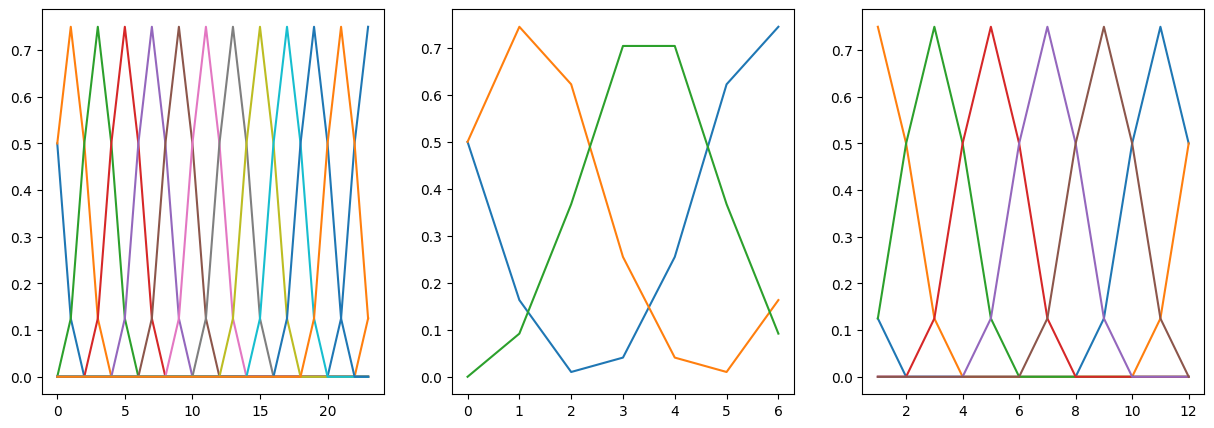

In [10]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import StandardScaler

def get_spline(degree, period, n_splines, df, feat):
    values = df[feat].values.reshape(-1,1)
    n_knots = n_splines + 1

    spline = SplineTransformer(degree=degree,
                             n_knots=n_knots, 
                             knots = np.linspace(0,period, n_knots).reshape(n_knots,1),
                             extrapolation = "periodic",
                             include_bias = True)
    spline_feat = spline.fit_transform(values)
    df_spline = pd.DataFrame(spline_feat, 
                             columns = [f"{feat}_cyclic_{i}" for i in range(spline_feat.shape[1])])
    
    return df_spline

fig, ax = plt.subplots(1,3, figsize = (15,5))

hr_spline = get_spline(degree = 2,
                       period = 24, 
                       n_splines = 12, 
                       df = df,
                       feat = "hour")

wk_spline = get_spline(degree = 2,
                       period = 7, 
                       n_splines = 3,
                       df = df,
                       feat = "weekday")

mo_spline = get_spline(degree = 2,
                       period = 12, 
                       n_splines = 6,
                       df = df,
                       feat = "month")

for i in range(hr_spline.shape[1]):
    idx = df["hour"].sort_values().index
    ax[0].plot(df["hour"].sort_values(),hr_spline.iloc[idx,i])
    
for i in range(wk_spline.shape[1]):
    idx = df["weekday"].sort_values().index
    ax[1].plot(df["weekday"].sort_values(),wk_spline.iloc[idx,i])
    
for i in range(mo_spline.shape[1]):
    idx = df["month"].sort_values().index
    ax[2].plot(df["month"].sort_values(),mo_spline.iloc[idx,i])
    


In [11]:
def prepare_data(df, categorical_feat, degree = 2, hr_splines = 12, wk_splines = 3, mo_splines = 6):
    
    # Get cyclic splines
    hr_spline = get_spline(degree = degree,
                       period = 24, 
                       n_splines = hr_splines, 
                       df = df,
                       feat = "hour")

    wk_spline = get_spline(degree = degree,
                           period = 7, 
                           n_splines = wk_splines,
                           df = df,
                           feat = "weekday")

    mo_spline = get_spline(degree = degree,
                           period = 12, 
                           n_splines = mo_splines,
                           df = df,
                           feat = "month")
    
    data = pd.concat([hr_spline, wk_spline, mo_spline], axis = 1)
    # Scale data
    scaler = StandardScaler().fit(data)
    X_scaled = scaler.transform(data)
    data = pd.DataFrame(X_scaled, columns = data.columns)
    
    if len(categorical_feat) > 0:
        df[categorical_feat] = df[categorical_feat].astype(str)
        df_categorical = pd.get_dummies(df[categorical_feat]).astype(int)
        # Get one-hot categorical
        data = pd.concat([df_categorical,data], axis = 1)

    X_scaled = data.values
    
    return X_scaled, df["response_time_minutes"], data

X_scaled, y, data = prepare_data(df, ["call_reason","call_taker","call_category"])

print("Mean response time: "+str(y.mean()))

data

Mean response time: 21.603559070687098


,call_reason_9-1-1 ABANDONED CALL,call_reason_9-1-1 HANG UP CALL,call_reason_9-1-1 TEST CALL,call_reason_ALARM,call_reason_ANIMAL CONTROL,call_reason_ASSAULT,call_reason_ASSIST OTHER AGENCY,call_reason_ASSIST OTHER AGENCY: MGRSD,call_reason_B.O.L.O.,call_reason_BREAKING & ENTRY,...,hour_cyclic_11,weekday_cyclic_0,weekday_cyclic_1,weekday_cyclic_2,month_cyclic_0,month_cyclic_1,month_cyclic_2,month_cyclic_3,month_cyclic_4,month_cyclic_5
0,0,0,0,0,0,0,0,0,0,0,...,-0.418483,-0.576528,1.466345,-0.906497,0.012105,2.299508,-0.210268,-0.670898,-0.698647,-0.706407
1,0,0,0,0,0,0,0,0,0,0,...,-0.418483,-0.576528,1.466345,-0.906497,0.012105,2.299508,-0.210268,-0.670898,-0.698647,-0.706407
2,0,0,0,0,0,0,0,0,0,0,...,-0.418483,-0.576528,1.466345,-0.906497,0.012105,2.299508,-0.210268,-0.670898,-0.698647,-0.706407
3,0,0,0,0,0,0,0,0,0,0,...,-0.418483,-1.155575,1.014552,0.112777,0.012105,2.299508,-0.210268,-0.670898,-0.698647,-0.706407
4,0,0,0,0,0,0,0,0,0,0,...,-0.418483,-1.155575,1.014552,0.112777,0.012105,2.299508,-0.210268,-0.670898,-0.698647,-0.706407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,0,0,0,0,0,0,0,0,0,0,...,-0.418483,1.160613,-1.244412,0.112777,1.782395,-0.605360,-0.703166,-0.670898,-0.698647,1.172083
4042,0,0,0,0,0,0,0,0,0,0,...,-0.418483,1.160613,-1.244412,0.112777,1.782395,-0.605360,-0.703166,-0.670898,-0.698647,1.172083
4043,0,0,0,0,0,0,0,0,1,0,...,-0.418483,1.160613,-1.244412,0.112777,1.782395,-0.605360,-0.703166,-0.670898,-0.698647,1.172083
4044,0,0,0,0,0,0,0,0,1,0,...,-0.418483,1.160613,-1.244412,0.112777,1.782395,-0.605360,-0.703166,-0.670898,-0.698647,1.172083


## Check Model Specifications

#### Check for Overdispersion

In [12]:
mu = df["response_time_minutes"].mean()
print(f"mu = {mu}")

mu = 21.603559070687098


In [13]:
variance = df["response_time_minutes"].var()
print(f"variance = {variance}")

variance = 375.95305531505124


Since $\text{Var}(T) > E(T)$ there is overdispersion.


In [14]:
endog = y.values[:] #response variable
exog = sm.add_constant(data, prepend = True) #predictor variable

#### Compute dispersion parameter

Unlike the Poisson regression model, the negative binomial model is designed to account for the presence of overdispersion, and in this case we have 

$$
\mu_i = E(T_i) < \text{Var}(T_i) = \mu_i(1 + \alpha \mu_i)
$$

where $\varphi$ is the dispersion parameter.To understand whether this is an appropriate model type, we will use the Cameron and Trivedi (CT) Test for overdispersion ([Cameron Trivedi, 1990](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C22&q=Regression-based+tests+for+overdispersion+in+the+Poisson+model.+J&btnG=)). 

This CT test measures for the significance of the overdispersion parameter by way of a hypothesis test, that is, we consider the null hypothese $H_0: \alpha = 0$ and the alternative hypothesis $H_1: \alpha > 0$. To run this test, we begin by estimating $\hat{\mu_i} = E(t_i)$ using a simple Poisson regression. Then, using these fitted values, we set up an auxiliary model
$$
Y_i = \frac{(t_i - \hat{\mu_i})^2 - t_i}{\hat{\mu_i}}
$$
with $Y_i = \alpha \hat{\mu_i}$.

In [15]:
poisson_model = sm.GLM(endog, exog, family = sm.families.Poisson(), missing = "drop")
poisson_model = poisson_model.fit()

y_hat_pr = poisson_model.predict(exog)
y_bar_pr = np.mean(endog)

print("Predicted Mean: " + str(np.around(y_hat_pr.mean(), decimals = 2)))
print("Predicted Variance: " + str(np.around(y_hat_pr.var(), decimals = 2)))

mu_hat = poisson_model.mu
n = endog.shape[0]
r = poisson_model._results.df_model

varphi = np.sum(((endog - mu_hat) ** 2) / mu_hat)/(n-r)

print(f"varphi = {np.around(varphi, decimals = 2)}")

poisson_model.summary().tables[0]

Predicted Mean: 21.61
Predicted Variance: 62.35
varphi = 14.52


Dep. Variable:,y,No. Observations:,4046
Model:,GLM,Df Residuals:,3962
Model Family:,Poisson,Df Model:,83
Link Function:,Log,Scale:,1.0000
Method:,IRLS,Log-Likelihood:,-31409.
Date:,"Sun, 14 Apr 2024",Deviance:,44359.
Time:,16:37:39,Pearson chi2:,5.76e+04
No. Iterations:,100,Pseudo R-squ. (CS):,0.9533
Covariance Type:,nonrobust,,


In [16]:
poisson_model = sm.GLM(endog, exog, family = sm.families.Poisson(sm.families.links.Log()), missing = "drop")
poisson_model = poisson_model.fit(scale = varphi)

mu_hat = poisson_model.mu
Y = (((endog - mu_hat) ** 2) - endog) / mu_hat

ols_results = sm.OLS(Y, mu_hat).fit()

alpha = ols_results.params[0]
print(f"alpha = {alpha}")

alpha = 0.5516939307291563


## Fit Models

#### Log Linear Regression

In [17]:
log_endog = np.log(endog)

linear_model = sm.OLS(log_endog, exog)
linear_model = linear_model.fit()

It looks like there are 0 significant features.


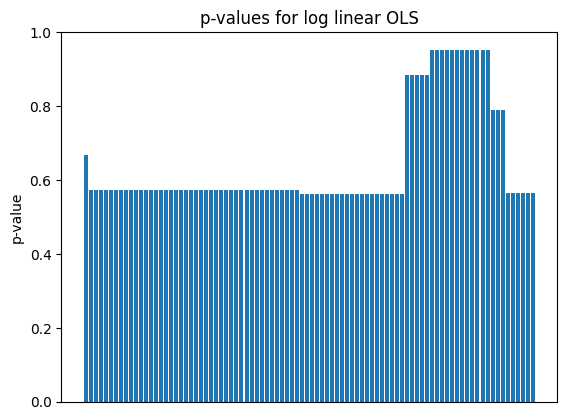

In [18]:
linear_results_as_html = linear_model.summary().tables[1].as_html()
linear_summary_df = pd.read_html(linear_results_as_html, header=0, index_col=0)[0]

sig_coef = linear_summary_df[linear_summary_df["P>|t|"] < 0.05].shape[0]
print(f"It looks like there are {sig_coef} significant features.")

fig, ax = plt.subplots()

ax.bar(x = linear_summary_df.index, height = linear_summary_df["P>|t|"])
ax.set_xticks([])
ax.set_ylabel("p-value")
ax.set_title("p-values for log linear OLS")
plt.show()

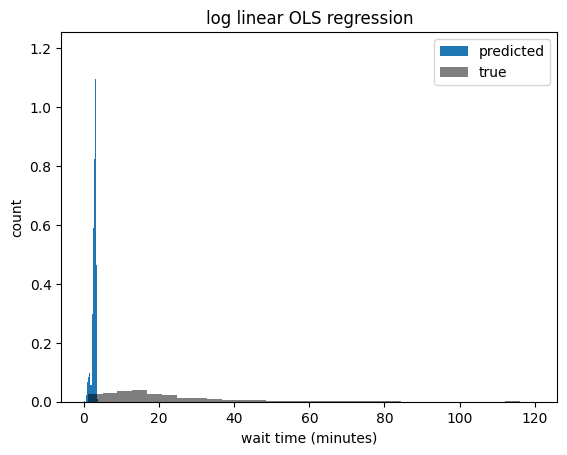

In [19]:
y_hat_linear = linear_model.predict(exog)
y_bar_linear = np.mean(endog)

model_selection_df.loc[0,"Model"] = "Log Linear OLS"

model_selection_df.loc[0,"AIC"] = linear_model.aic
model_selection_df.loc[0,"BIC"] = linear_model.bic
model_selection_df.loc[0,"RMSE"] = (np.sum((endog - y_hat_linear)**2)/len(endog)) ** (1/2)
model_selection_df.loc[0,"R^2"] = linear_model.rsquared#1 - (np.sum((endog - y_hat_linear) ** 2) / np.sum((endog - y_bar_linear) ** 2))
model_selection_df.loc[0,"significant coef (p < 0.05)"] = sig_coef

fig, ax = plt.subplots()

ax.hist(y_hat_linear, bins = 30, label = "predicted", density = True)
ax.hist(endog, bins = 30, label = "true", color = "k", alpha = 0.5, density = True)
ax.set_xlabel("wait time (minutes)")
ax.set_ylabel("count")
ax.legend()

ax.set_title("log linear OLS regression")
plt.show()

#### Gaussian GLM with Log Link

In [20]:
gaussian_model = sm.GLM(endog, exog, family = sm.families.Gaussian(link=sm.families.links.Log()), missing = "drop")
gaussian_model = gaussian_model.fit()

It looks like there are 40 significant features.


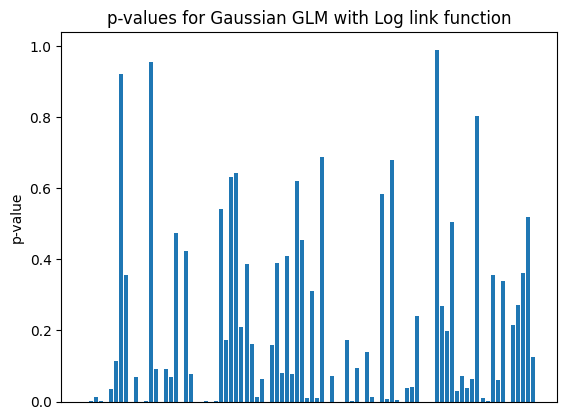

In [21]:
gaussian_results_as_html = gaussian_model.summary().tables[1].as_html()
gaussian_summary_df = pd.read_html(gaussian_results_as_html, header=0, index_col=0)[0]

sig_coef = gaussian_summary_df[gaussian_summary_df["P>|z|"] < 0.05].shape[0]
print(f"It looks like there are {sig_coef} significant features.")

fig, ax = plt.subplots()

ax.bar(x = gaussian_summary_df.index, height = gaussian_summary_df["P>|z|"])
ax.set_xticks([])
ax.set_ylabel("p-value")
ax.set_title("p-values for Gaussian GLM with Log link function")
plt.show()

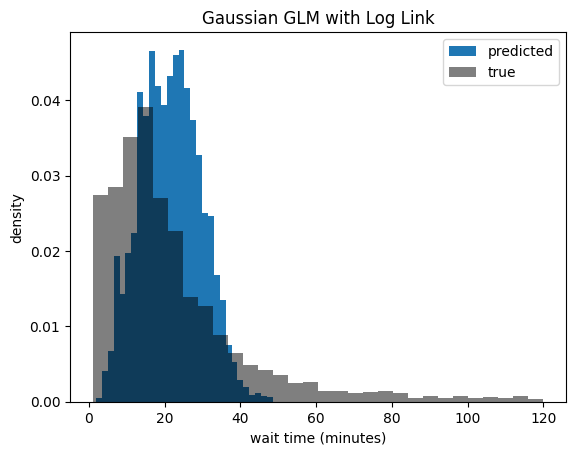

In [22]:
y_hat_gaussian = gaussian_model.predict(exog)
y_bar_gaussian = np.mean(endog)

model_selection_df.loc[1,"Model"] = "Gaussian GLM with Log Link"

model_selection_df.loc[1,"AIC"] = gaussian_model.aic
model_selection_df.loc[1,"BIC"] = gaussian_model.bic_llf
model_selection_df.loc[1,"RMSE"] = (np.sum((endog - y_hat_gaussian)**2)/len(endog)) ** (1/2)
model_selection_df.loc[1,"R^2"] = 1 - (np.sum((endog - y_hat_gaussian) ** 2) / np.sum((endog - y_bar_gaussian) ** 2))
model_selection_df.loc[1,"Cox-Snell pseudo R^2"] = gaussian_model.pseudo_rsquared()
model_selection_df.loc[1,"significant coef (p < 0.05)"] = sig_coef

fig, ax = plt.subplots()

ax.hist(y_hat_gaussian, bins = 30, label = "predicted", density = True)
ax.hist(endog, bins = 30, label = "true", color = "k", alpha = 0.5, density = True)
ax.set_xlabel("wait time (minutes)")
ax.set_ylabel("density")
ax.legend()

ax.set_title("Gaussian GLM with Log Link")
plt.show()

#### Gamma Regression

In [23]:
gamma_model = sm.GLM(endog, exog, family = sm.families.Gamma(link=sm.families.links.Log()), missing = "drop")
gamma_model = gamma_model.fit()

It looks like there are 0 significant features.


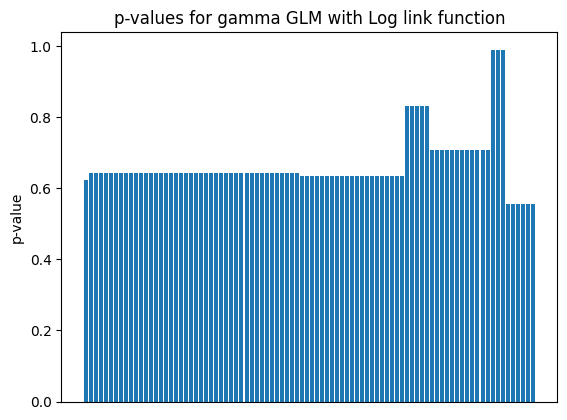

In [24]:
gamma_results_as_html = gamma_model.summary().tables[1].as_html()
gamma_summary_df = pd.read_html(gamma_results_as_html, header=0, index_col=0)[0]

sig_coef = gamma_summary_df[gamma_summary_df["P>|z|"] < 0.05].shape[0]
print(f"It looks like there are {sig_coef} significant features.")

fig, ax = plt.subplots()

ax.bar(x = gamma_summary_df.index, height = gamma_summary_df["P>|z|"])
ax.set_xticks([])
ax.set_ylabel("p-value")
ax.set_title("p-values for gamma GLM with Log link function")
plt.show()

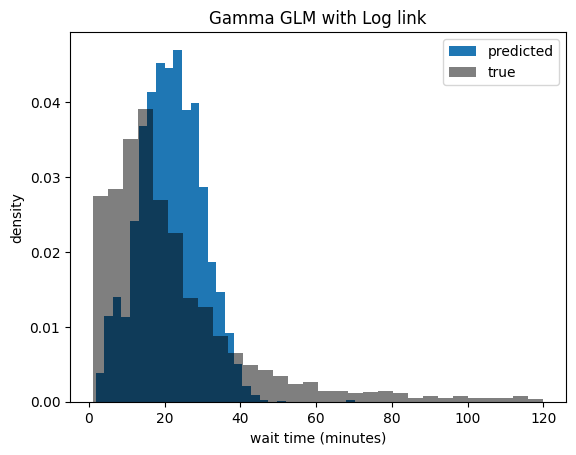

In [25]:
y_hat_gamma = gamma_model.predict(exog)
y_bar_gamma = np.mean(endog)

model_selection_df.loc[2,"Model"] = "Gamma GLM with Log Link"

model_selection_df.loc[2,"AIC"] = gamma_model.aic
model_selection_df.loc[2,"BIC"] = gamma_model.bic_llf
model_selection_df.loc[2,"RMSE"] = (np.sum((endog - y_hat_gamma)**2)/len(endog)) ** (1/2)
model_selection_df.loc[2,"R^2"] = 1 - (np.sum((endog - y_hat_gamma) ** 2) / np.sum((endog - y_bar_gamma) ** 2))
model_selection_df.loc[2,"Cox-Snell pseudo R^2"] = gamma_model.pseudo_rsquared()
model_selection_df.loc[2,"significant coef (p < 0.05)"] = sig_coef

fig, ax = plt.subplots()

ax.hist(y_hat_gamma, bins = 30, label = "predicted", density = True)
ax.hist(endog, bins = 30, label = "true", color = "k", alpha = 0.5, density = True)
ax.set_xlabel("wait time (minutes)")
ax.set_ylabel("density")
ax.legend()

ax.set_title("Gamma GLM with Log link")
plt.show()

#### Negative Binomial 

In [26]:
nb_model = sm.GLM(endog, exog, family = sm.families.NegativeBinomial(link=sm.families.links.Log(),alpha=alpha), missing = "drop")
nb_model = nb_model.fit()

It looks like there are 42 significant features.


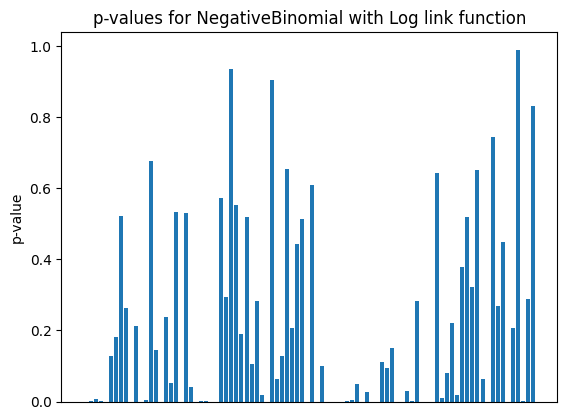

In [27]:
nb_results_as_html = nb_model.summary().tables[1].as_html()
nb_summary_df = pd.read_html(nb_results_as_html, header=0, index_col=0)[0]

sig_coef = nb_summary_df[nb_summary_df["P>|z|"] < 0.05].shape[0]
print(f"It looks like there are {sig_coef} significant features.")

fig, ax = plt.subplots()

ax.bar(x = nb_summary_df.index, height = nb_summary_df["P>|z|"])
ax.set_xticks([])
ax.set_ylabel("p-value")
ax.set_title("p-values for NegativeBinomial with Log link function")
plt.show()

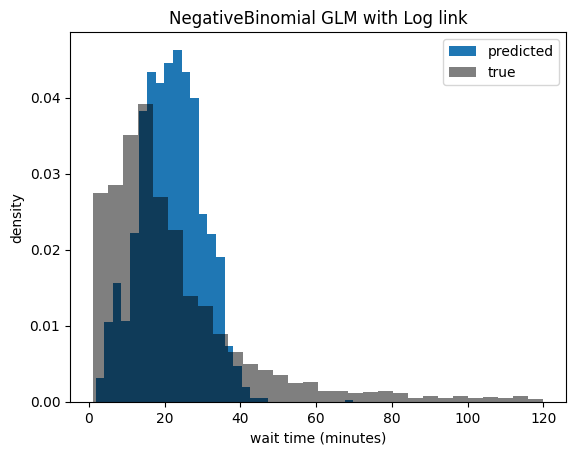

In [28]:
y_hat_nb = nb_model.predict(exog)
y_bar_nb = np.mean(endog)

model_selection_df.loc[3,"Model"] = "Negative Binomial GLM with Log Link"

model_selection_df.loc[3,"AIC"] = nb_model.aic
model_selection_df.loc[3,"BIC"] = nb_model.bic_llf
model_selection_df.loc[3,"RMSE"] = (np.sum((endog - y_hat_nb)**2)/len(endog)) ** (1/2)
model_selection_df.loc[3,"R^2"] = 1 - (np.sum((endog - y_hat_nb) ** 2) / np.sum((endog - y_bar_nb) ** 2))
model_selection_df.loc[3,"Cox-Snell pseudo R^2"] = nb_model.pseudo_rsquared()
model_selection_df.loc[3,"significant coef (p < 0.05)"] = sig_coef

fig, ax = plt.subplots()

ax.hist(y_hat_nb, bins = 30, label = "predicted", density = True)
ax.hist(endog, bins = 30, label = "true", color = "k", alpha = 0.5, density = True)
ax.set_xlabel("wait time (minutes)")
ax.set_ylabel("density")
ax.legend()

ax.set_title("NegativeBinomial GLM with Log link")
plt.show()

## Model Analysis

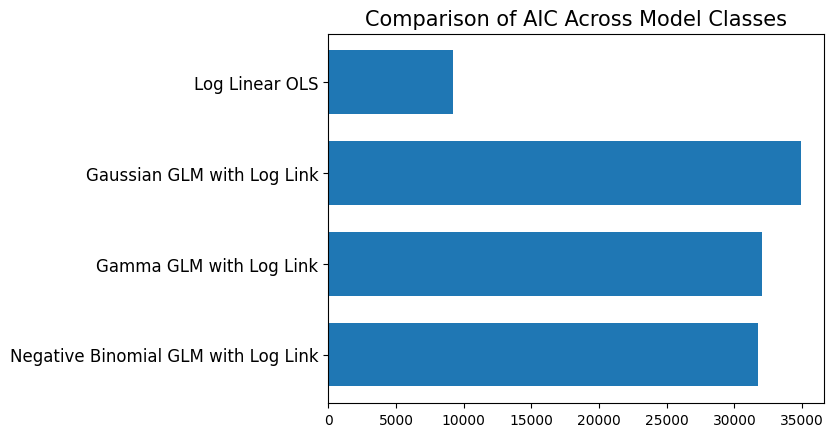

The model with the lowest AIC is best


In [32]:
models = model_selection_df["Model"]
y_values =  np.array([0,1,2, 3])
y_labels = model_selection_df["Model"].values

aic = model_selection_df["AIC"].values[::-1]

fig, ax = plt.subplots()

ax.barh(y = y_values, width = aic, height = .7, label = "AIC")

ax.set_yticks(y_values)
ax.set_yticklabels(y_labels[::-1], fontsize = 12)

plt.title("Comparison of AIC Across Model Classes", fontsize = 15)
plt.show()

print("The model with the lowest AIC is best")

In [33]:
model_selection_df

,Model,AIC,BIC,R^2,Cox-Snell pseudo R^2,RMSE,significant coef (p < 0.05)
0,Log Linear OLS,9244.340141,9774.000799,0.343992,NaN,26.927060,0.0
1,Gaussian GLM with Log Link,34899.840685,35429.501343,0.167358,0.178092,17.690593,40.0
2,Gamma GLM with Log Link,32038.8991,32568.559758,0.155658,0.18577,17.814450,0.0
3,Negative Binomial GLM with Log Link,31738.15819,32267.818848,0.15994,0.241941,17.769214,42.0


## K-Fold Cross Validation of 

#### NB Model

In [28]:
# from sklearn.model_selection import KFold

# gaussian_trial_fits = []

# for j in range(100):
#     kf = KFold(n_splits=10)
#     fold_fit_df = pd.DataFrame()

#     for i, (train_index, test_index) in enumerate(kf.split(exog)):
        
#         fold_fit_df.loc[i,"fold"] = i
        
#         exog_train = exog.loc[train_index,:]
#         exog_test = exog.loc[test_index,:]

#         endog_train = df.loc[train_index, "response_time_minutes"]
#         endog_test = df.loc[test_index, "response_time_minutes"]
        
#         gaussian_model = sm.GLM(endog_train, exog_train, family = sm.families.Gaussian(link=sm.families.links.Log()), missing = "drop")
#         gaussian_model = gaussian_model.fit()

#         y_hat_train = gaussian_model.predict(exog_train)
#         y_bar_train = np.mean(endog_train)

#         y_hat_test = gaussian_model.predict(exog_test)
#         y_bar_test = np.mean(endog_test)

#         fold_fit_df.loc[i,"RMSE_train"] = (np.sum((endog_train - y_hat_train)**2)/len(endog_train)) ** (1/2)
#         fold_fit_df.loc[i,"R^2_train"] = 1 - (np.sum((endog_train - y_hat_train) ** 2) / np.sum((endog_train - y_bar_train) ** 2))

#         fold_fit_df.loc[i,"RMSE_test"] = (np.sum((endog_test - y_hat_test)**2)/len(endog_test)) ** (1/2)
#         fold_fit_df.loc[i,"R^2_test"] = 1 - (np.sum((endog_test - y_hat_test) ** 2) / np.sum((endog_test - y_bar_test) ** 2))

#     gaussian_trial_fits.append(fold_fit_df)
    
# df_gaussian_fits = pd.concat(gaussian_trial_fits)
# df_gaussian_fits.reset_index(drop = True, inplace = True)

# df_gaussian_fits

In [29]:
# df_gaussian_fits.to_csv("2024_04_01_gaussian_10foldcv.csv")
# #df_gaussian_fits = pd.read_csv("2024_04_01_gaussian_10foldcv.csv", index_col = 0)

# print("Gaussian GLM with Log Link:")
# print("")
# train_mean = np.around(df_gaussian_fits["RMSE_train"].mean(), decimals = 2)
# train_std = np.around(df_gaussian_fits["RMSE_train"].std(), decimals = 2)
# test_mean = np.around(df_gaussian_fits["RMSE_test"].mean(), decimals = 2)
# test_std = np.around(df_gaussian_fits["RMSE_test"].std(), decimals = 2)
# print(f"RMSE    {train_mean} \pm {train_std}     {test_mean} \pm {test_std}")

# train_mean = np.around(df_gaussian_fits["R^2_train"].mean(), decimals = 2)
# train_std = np.around(df_gaussian_fits["R^2_train"].std(), decimals = 2)
# test_mean = np.around(df_gaussian_fits["R^2_test"].mean(), decimals = 2)
# test_std = np.around(df_gaussian_fits["R^2_test"].std(), decimals = 2)
# print(f"R^2    {train_mean} \pm {train_std}     {test_mean} \pm {test_std}")

#### NB Model

In [30]:
# nb_model = sm.GLM(endog, exog, family = sm.families.NegativeBinomial(link=sm.families.links.Log(),alpha=alpha), missing = "drop")
# nb_model = nb_model.fit()

# nb_results_as_html = nb_model.summary().tables[1].as_html()
# nb_summary_df = pd.read_html(nb_results_as_html, header=0, index_col=0)[0]
# df_sig = pd.DataFrame(index = exog.columns)
# sig_coef = nb_summary_df[nb_summary_df["P>|z|"] < 0.05]

# sig_binary = [i for i in sig_coef.index if not "cyclic" in i]
# sig_cyclic = [i for i in nb_summary_df.index if "cyclic" in i]

In [31]:
# sig_exog = exog.loc[:,sig_binary + sig_cyclic]

In [32]:
# from sklearn.model_selection import KFold

# trial_fits = []
# trial_coefs = []

# for j in range(100):
#     kf = KFold(n_splits=10)
#     fold_fit_df = pd.DataFrame()
#     fold_coef_df = pd.DataFrame(index = [c for c in exog.columns])
#     for i, (train_index, test_index) in enumerate(kf.split(exog)):
        
#         fold_fit_df.loc[i,"fold"] = i
        
#         exog_train = exog.loc[train_index,:]
#         exog_test = exog.loc[test_index,:]

#         endog_train = df.loc[train_index, "response_time_minutes"]
#         endog_test = df.loc[test_index, "response_time_minutes"]

#         nb_model = sm.GLM(endog_train, exog_train, family = sm.families.NegativeBinomial(link=sm.families.links.Log(),alpha=alpha), missing = "drop")
#         #nb_model = nb_model.fit_regularized(L1_wt=0, alpha=0.1)
#         nb_model = nb_model.fit()

#         y_hat_nb_train = nb_model.predict(exog_train)
#         y_bar_nb_train = np.mean(endog_train)

#         y_hat_nb_test = nb_model.predict(exog_test)
#         y_bar_nb_test = np.mean(endog_test)

#         fold_fit_df.loc[i,"RMSE_train"] = (np.sum((endog_train - y_hat_nb_train)**2)/len(endog_train)) ** (1/2)
#         fold_fit_df.loc[i,"R^2_train"] = 1 - (np.sum((endog_train - y_hat_nb_train) ** 2) / np.sum((endog_train - y_bar_nb_train) ** 2))

#         fold_fit_df.loc[i,"RMSE_test"] = (np.sum((endog_test - y_hat_nb_test)**2)/len(endog_test)) ** (1/2)
#         fold_fit_df.loc[i,"R^2_test"] = 1 - (np.sum((endog_test - y_hat_nb_test) ** 2) / np.sum((endog_test - y_bar_nb_test) ** 2))
        
#         if fold_fit_df.loc[i,"RMSE_train"] > 100:
#             print("Noooo")
#             break
#         nb_results_as_html = nb_model.summary().tables[1].as_html()
#         nb_summary_df = pd.read_html(nb_results_as_html, header=0, index_col=0)[0]
        
#         fold_coef_df[f"{j}_{i}"] = nb_summary_df["coef"].values
        
#     trial_fits.append(fold_fit_df)
#     trial_coefs.append(fold_coef_df)
    
# df_nb_fits = pd.concat(trial_fits)
# df_nb_fits.reset_index(drop = True, inplace = True)

# df_coefs = pd.concat(trial_coefs, axis = 1)
# df_coefs.reset_index(drop = True, inplace = True)

## Sensitivity Analysis

This section will follow the frameowrk for Omitted Variable Bias (OVB) as presented by [Cinelli et al.](https://rss.onlinelibrary.wiley.com/doi/10.1111/rssb.12348).  Recall that the generalized linear model underlying out negative binomial regression model has the form 
$$
\log(\text{response_time}) = y = \beta_0 + \sum \beta_{X\mid Z} X + \beta Z  + \epsilon
$$
Where $Z$ is a vector of unobserved confounding variables, and $\epsilon$ is the model error.  We can't directly fit this model, since $Z$ contains unmeasured confounding values such as e.g. historical violence at caller address.  

The coefficient of determination, 
$$
R_{zx}^2 = \frac{\sum(\hat{x} - \overline{x})^2}{\sum (x - \overline{x})^2}
$$
gives the proportion of variation in $X$ explained by $Z$, where $x = \alpha_0 + \alpha_1z_1 + ...+ \alpha_pz_p$ is fit with least squares, $\overline{x}$ is the mean, and $\hat{x}$ are the fitted values.  The coefficient of determination $R_{zy}$ is defined similarly, and 
$$
\rho_{\hat{x}\hat{y}} = \frac{\langle \hat{x} - \overline{\hat{x}}\rangle}{\mid \hat{x} - \overline{x}\mid \mid \hat{y} - \overline{\hat{y}}\mid}
$$ 
is the Pearson correlation coefficient between the two vectors of fitted values.

Suppose $0\leq R_{zx}^2\leq .5$, that is, up to 50\% of the variation in the independent variable is explained by the unmeasured counfounder.  Suppose similarly, that $0\leq R_{zy}^2\leq .5$, that is, up to 50\% of the variation in the dependent variable is explained by the confounder. 

In [39]:
df_sa = pd.DataFrame()
df_sa["Estimate"] = coef_df.mean(axis = 1)
df_sa["Standard Error"] = coef_df.std(axis = 1) / coef_df.shape[1]
df_sa["sigma_x"] = exog.std(axis = 0)
df_sa["sigma_y / sigma_x"] = np.std(np.log(endog)) / df_sa["sigma_x"]
df_sa

,Estimate,Standard Error,sigma_x,sigma_y / sigma_x
const,1.510172,0.000011,0.000000,inf
call_reason_9-1-1 ABANDONED CALL,1.101890,0.000175,0.137468,6.662369
call_reason_9-1-1 HANG UP CALL,1.054799,0.000177,0.107126,8.549455
call_reason_9-1-1 OVERFLOW NORTH ADAMS,0.134753,0.000049,0.015715,58.278136
call_reason_9-1-1 TEST CALL,1.236820,0.000177,0.097681,9.376082
...,...,...,...,...
month_cyclic_1,0.312866,0.000034,0.000000,inf
month_cyclic_2,0.228298,0.000027,0.000000,inf
month_cyclic_3,0.081987,0.000027,0.000000,inf
month_cyclic_4,0.273236,0.000028,0.000000,inf


In [34]:
x = np.asarray(exog.iloc[:,1:])
y = endog
np.corrcoef(x,y,rowvar = False)

array([[ 1.        , -0.01529874, -0.01392211, ...,  0.00412522,
        -0.04432011, -0.03590473],
       [-0.01529874,  1.        , -0.01069537, ...,  0.04142096,
         0.03390812, -0.03728343],
       [-0.01392211, -0.01069537,  1.        , ...,  0.02683582,
         0.01346704, -0.01742418],
       ...,
       [ 0.00412522,  0.04142096,  0.02683582, ...,  1.        ,
         0.12629647,  0.00672965],
       [-0.04432011,  0.03390812,  0.01346704, ...,  0.12629647,
         1.        ,  0.03010711],
       [-0.03590473, -0.03728343, -0.01742418, ...,  0.00672965,
         0.03010711,  1.        ]])

In [35]:
import scipy
scipy.stats.pearsonr(x,y)

ValueError: shapes (4046,89) and (4046,) not aligned: 89 (dim 1) != 4046 (dim 0)